## <center>Курсовой проект<center>

### Подготовка

In [1]:
# Отключаю предупреждения

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импортирую необходимые модули, библиотеки, функции, классы

import numpy as np
import pandas as pd
import pickle
import random

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, \
classification_report, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.ensemble import RandomForestClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Задаю везде одинаковый размер шрифта

matplotlib.rcParams.update({'font.size': 14})

In [4]:
# Функция вывода отчетов

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
# Функция балансировки 

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [6]:
# Функция вывода графики с иллюстрацией оптимальной отсечки по тесту

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
# Функция отрисовки графиков зависимости метрики от объема выборки

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
# Функция вывода важности признаков

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Обзор обучающего датасета

In [9]:
# Пути к обучающему и тестовому датасетам

TRAIN_DATASET_PATH = '../course_project_train.csv'
TEST_DATASET_PATH = '../course_project_test.csv'

In [10]:
# Смотрю обучающий датасет и признаки

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг

* **Credit Score** - НЕИЗВЕСТНЫЙ ПРИЗНАК

* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [11]:
# Смотрю размер обучающего датасета

df_train.shape

(7500, 17)

In [12]:
# Смотрю информацию об обучающем датасете - вижу пропуски, в том числе в категориальном признаке Years in current job

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
# Смотрю первую строку обучающего датасета

df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [14]:
# Смотрю соотношение значений целевой переменной Credit Default
# Имеется дисбаланс классов (приблизительное соотношение 2,5:1)

df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

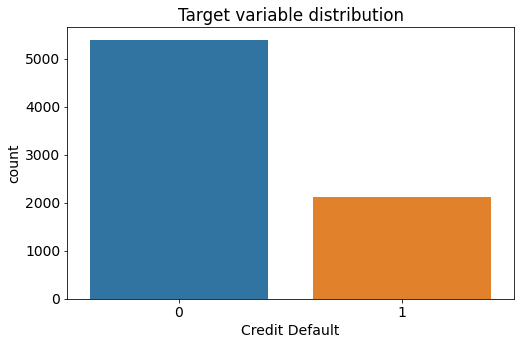

In [15]:
# Смотрю распределение целевой переменной Credit Default

plt.figure(figsize=(8, 5))

sns.countplot(x='Credit Default', data=df_train)

plt.title('Target variable distribution')
plt.show()

In [16]:
# Смотрю количественные признаки

# Вижу пропуски в Annual Income, Months since last delinquent, Bankruptcies, Credit Score
# Вижу подозрительные значения для некоторых признаков в min (0 - наибольший открытый кредит) 
# и max (43 - количество открытых счетов, 118 - количество месяцев с последней просрочки платежа, 
# 100000000 - текущая сумма кредита)
# Сравниваю среднее (mean) и медиану (50%). Если среднее больше медианы - значит справа выбросы. 
# Здесь выделяются Current Loan Amount, Credit Score

df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [17]:
# Смотрю номинативные признаки
# Home Ownership - домовладение
# Years in current job - количество лет на текущем месте работы
# Purpose - цель кредита
# Term - срок кредита

for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка пропусков

In [18]:
# Обнаруживаю пропуски 

len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [19]:
# Заменяю пропуски в признаке Annual Income на медиану

df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)
df_train['Annual Income'].isna().sum()

0

In [20]:
# Заполняю пропуски в признаке Years in current job модой

df_train['Years in current job'].fillna(df_train['Years in current job'].mode()[0], inplace=True)
df_train['Years in current job'].isna().sum()

0

In [21]:
# Вижу в признаке Months since last delinquent пропуски, количество которых больше половины - убираю его

df_train = df_train.drop('Months since last delinquent', axis=1)

In [22]:
# Заполняю пропуски в признаке Bankruptcies модой

df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].mode()[0], inplace=True)
df_train['Bankruptcies'].isna().sum()

0

In [23]:
# В тестовом датасете у признака Purpose отсутствует категория renewable energy 
# Таким образом, после создания dummy переменных в обучающем датасете будет на один признак больше 
# С учетом количества кредитов 2 шт. на renewable energy считаю, что данная категория не окажет значимого 
# влияния на качество предсказаний и отношу записи с ней в другую категорию - other

df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [24]:
df_train['Purpose'].loc[df_train['Purpose'] == 'renewable energy'] = 'other'

In [25]:
# Заменяю пропуски в признаке Credit Score на медиану

df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace=True)
df_train['Credit Score'].isna().sum()

0

In [26]:
# Проверяю на отсутствие пропусков

df_train.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

### Обработка выбросов

In [27]:
# Поработаю с признаком Maximum Open Credit
# Это наибольший открытый кредит, поэтому предполагаю, что нулевых значений тут быть не может

df_train['Maximum Open Credit'].value_counts()

0.0         65
319110.0     5
246224.0     3
344058.0     3
513524.0     3
            ..
668360.0     1
642224.0     1
779372.0     1
372812.0     1
480832.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [28]:
df_train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [29]:
# Вижу 65 отклонений

df_train[df_train['Maximum Open Credit'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,731.0,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,Home Mortgage,1168386.0,8 years,0.0,10.0,13.0,0.0,0.0,0.0,debt consolidation,Long Term,672078.0,19.0,8860.0,731.0,0
6851,Home Mortgage,2251728.0,10+ years,0.0,8.0,15.4,0.0,0.0,0.0,home improvements,Long Term,760452.0,0.0,36778.0,725.0,0
7014,Home Mortgage,1223771.0,5 years,0.0,9.0,24.0,0.0,0.0,0.0,small business,Long Term,751454.0,0.0,15348.0,737.0,1
7124,Rent,1168386.0,1 year,0.0,4.0,11.0,0.0,0.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,731.0,0


In [30]:
# Заменяю нулевые значения в Maximum Open Credit на моду
# Вижу, что теперь значения признака Maximum Open Credit вписываются в объективные

df_train.loc[df_train['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = df_train['Maximum Open Credit'].mode()[0]
df_train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

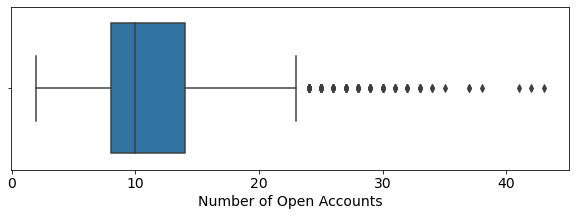

In [31]:
# Ищу выбросы в Number of Open Accounts с помощью box plot

plt.figure(figsize=(10, 3))

sns.boxplot(df_train['Number of Open Accounts'], whis=1.5)

plt.xlabel('Number of Open Accounts')
plt.show()

In [32]:
# Заменяю выбросы в Number of Open Accounts на медиану

df_train.loc[df_train['Number of Open Accounts'] > 23, 'Number of Open Accounts'] = df_train['Number of Open Accounts'].median()

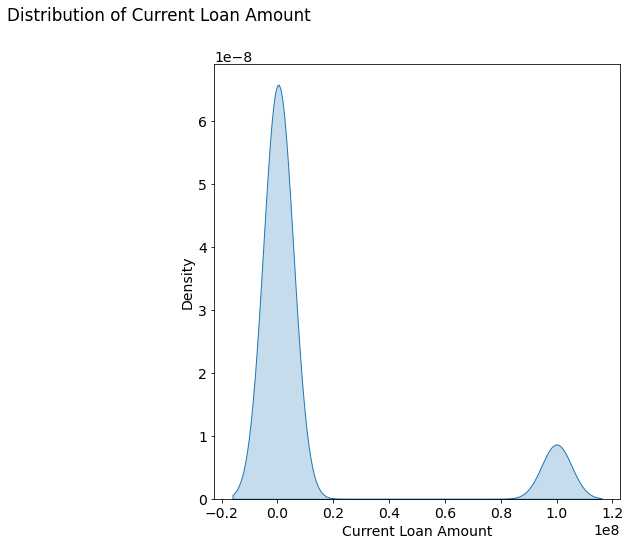

In [33]:
# Поработаю с признаком Current Loan Amount

plt.figure(figsize = (16, 8))

plt.subplot(122)
sns.kdeplot(df_train['Current Loan Amount'], shade=True, legend=False)
plt.xlabel('Current Loan Amount')

plt.suptitle('Distribution of Current Loan Amount')
plt.show()

In [34]:
# Скачок в районе 100 млн выглядит странно

df_train['Current Loan Amount'].max()

99999999.0

In [35]:
# Более того - это еще и самое часто встречающеея значение

df_train['Current Loan Amount'].mode()

0    99999999.0
Name: Current Loan Amount, dtype: float64

In [36]:
# Предполагаю, что это какое-то стандартное заведомо большое значение размера кредита для заполнения случаев, 
# когда истинная сумма неизвестна

df_train['Current Loan Amount'].loc[df_train['Current Loan Amount'] == 99999999.0].count()

870

In [37]:
# Расцениваю это как выбросы и с учетом количества таких примеров, считаю что они могут повлиять на итоговые предсказания -
# поэтому заменяю их на медиану

df_train['Current Loan Amount'].loc[df_train['Current Loan Amount'] == 99999999.0] = df_train['Current Loan Amount'].median() 

### Анализ данных

In [38]:
# Обрабатываю категориальные признаки: 
# бинарный перевод для признака Term 
# порядковые числа для признака Years in current job
# бинарное кодирование через dummy-переменные для признаков Home Ownership и Purpose

df_train['Term'] = df_train['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)

In [39]:
df_train['Years in current job'] = df_train['Years in current job'].map({
                                                                        '10+ years':'10', 
                                                                        '< 1 year':'0',
                                                                        '1 year':'1',    
                                                                        '2 years':'2',
                                                                        '3 years':'3',
                                                                        '4 years':'4',
                                                                        '5 years':'5',
                                                                        '6 years':'6',
                                                                        '7 years':'7',
                                                                        '8 years':'8',
                                                                        '9 years':'9'}).astype(int)

In [40]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [41]:
df_train = df_train.drop(df_train.select_dtypes(include='object').columns, axis=1)

In [42]:
df_train.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,482087.0,10,0.0,11.0,26.3,685960.0,1.0,1.0,0,309573.0,...,0,0,0,0,0,0,0,0,0,0
1,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,1,264968.0,...,0,0,0,0,0,0,0,0,0,0
2,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0,309573.0,...,0,0,0,0,0,0,0,0,0,0
3,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,0,121396.0,...,0,0,0,0,0,0,0,0,0,0
4,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0,125840.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Выделяю количественные признаки

df_num_features = df_train.select_dtypes(include=['float64', 'float32', 'float16', 'int8'])
df_num_features

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,1.0,309573.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,0.0,309573.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,0.0,125840.0,93309.0,7180.0,719.0
...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.5,107866.0,0.0,0.0,129360.0,73492.0,1900.0,697.0
7496,1533984.0,0.0,10.0,26.5,686312.0,0.0,0.0,444048.0,456399.0,12783.0,7410.0
7497,1878910.0,0.0,12.0,32.1,1778920.0,0.0,0.0,309573.0,477812.0,12479.0,748.0
7498,1168386.0,0.0,21.0,26.5,1141250.0,0.0,0.0,615274.0,476064.0,37118.0,731.0


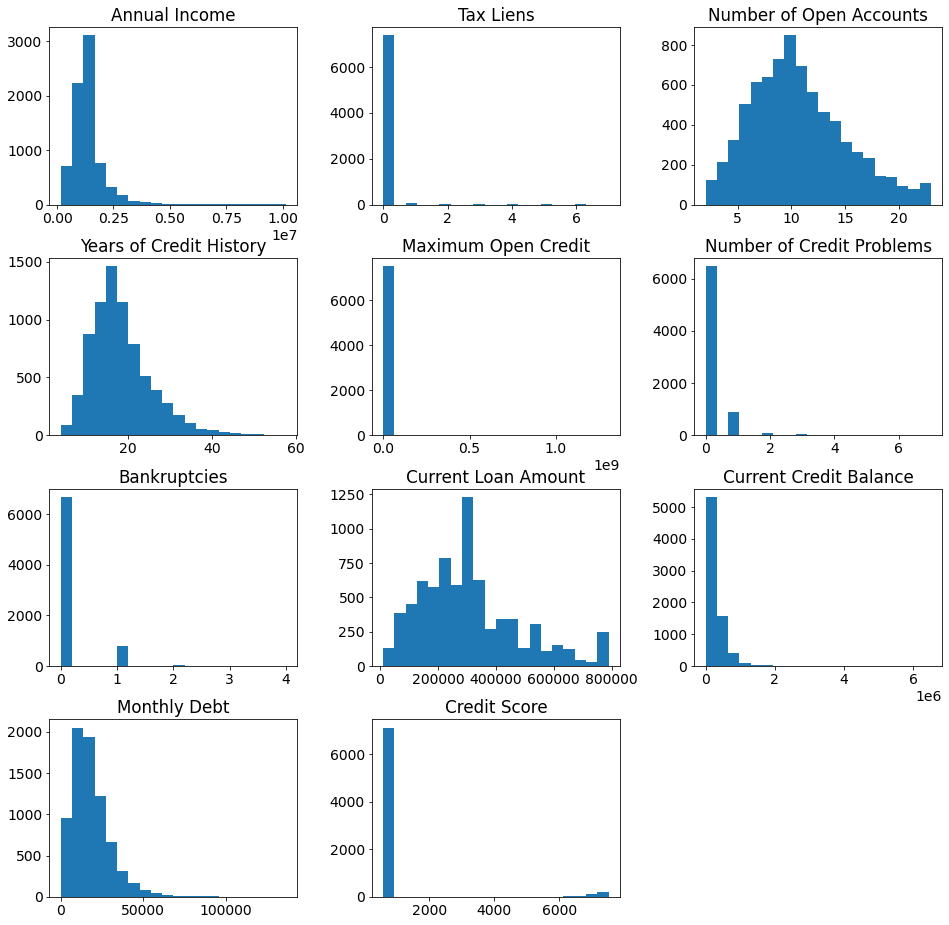

In [44]:
# Изучаю гистограммы их распределения

df_num_features.hist(figsize=(16,16), bins=20, grid=False);

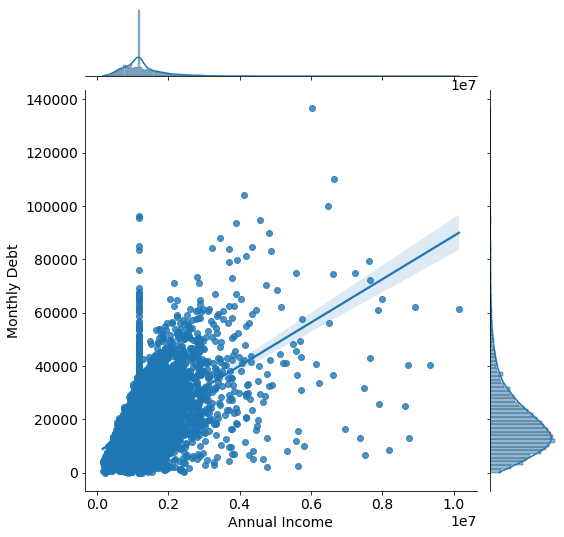

In [45]:
# Вижу слабую прямую линейную зависимость между признаками Annual Income (годовой доход) и Monthly Debt (ежемесячный долг)

grid = sns.jointplot(df_train['Annual Income'], df_train['Monthly Debt'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### Сохранение предобработанного (подготовленного) обучающего датасета

In [46]:
PREP_DATASET_PATH  = '../course_project_train_prep.csv'

df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [47]:
# input
DATASET_PATH = './course_project_train.csv'

# output
TRAIN_FULL_PATH = './course_project_train_full.csv'
TRAIN_PART_PATH = './course_project_train_part_b.csv'
TEST_PART_PATH = '../course_project_test_part.csv'

MODEL_FILE_PATH = './model.pkl'

### Отбор признаков

In [48]:
target_name = 'Credit Default'
feature_names = df_train.columns.drop(target_name).tolist()

In [49]:
feature_names

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding']

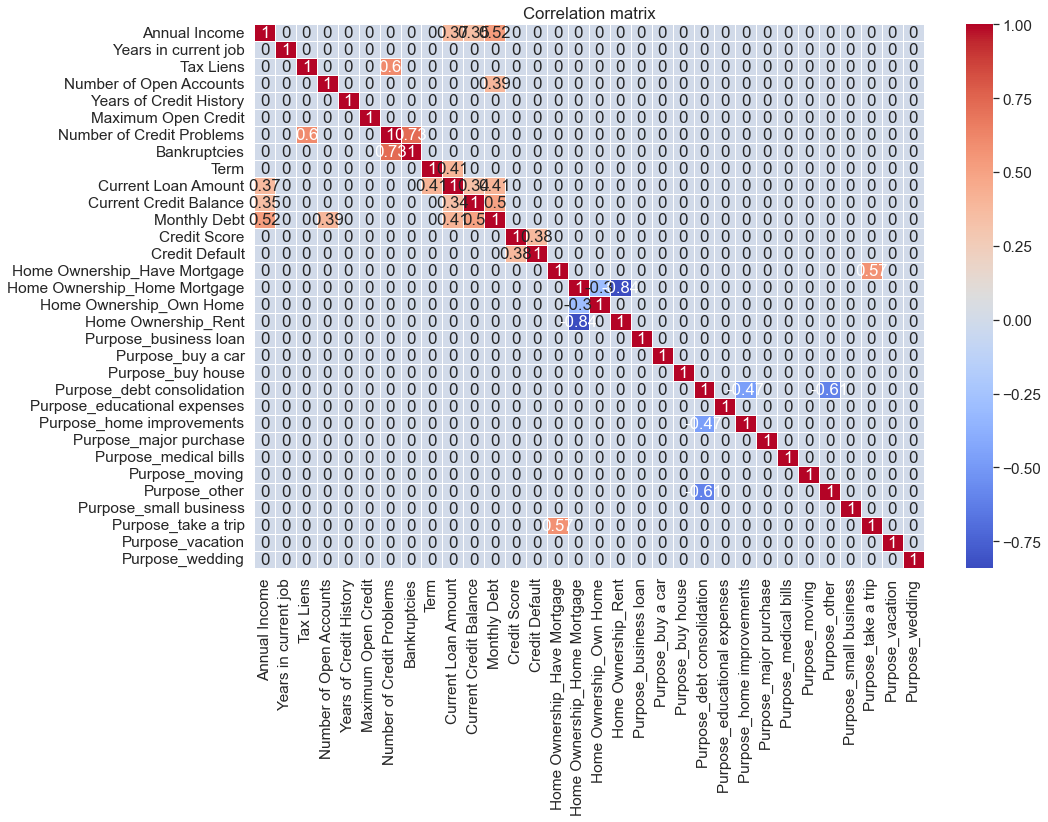

In [50]:
# Оцениванию мультиколлинеарность признаков с помощью матрицы корреляций

plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [51]:
# Разбиваю на train и test

X = df_train[feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42, stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

### Балансировка классов

In [52]:
# Балансировка классов в целевой переменной

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

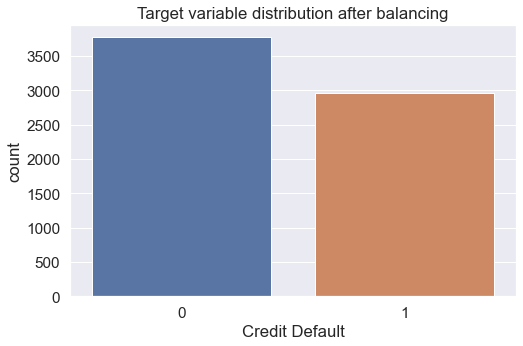

In [53]:
# Смотрю новое распределение целевой переменной Credit Default

plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=df_balanced)

plt.title('Target variable distribution after balancing')
plt.show()

### Подбор моделей, получение бейзлайна

In [54]:
%%time

model_lr = LogisticRegression(class_weight={0: 1, 1: 2.55}, random_state=42)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      3771
           1       0.40      0.62      0.48      1479

    accuracy                           0.63      5250
   macro avg       0.60      0.63      0.60      5250
weighted avg       0.69      0.63      0.65      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.61      0.70      1616
           1       0.38      0.62      0.47       634

    accuracy                           0.61      2250
   macro avg       0.59      0.61      0.58      2250
weighted avg       0.68      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               991  625
1               244  390
Wall time: 219 ms


In [55]:
%%time

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3771
           1       0.67      0.40      0.50      1479

    accuracy                           0.78      5250
   macro avg       0.73      0.66      0.68      5250
weighted avg       0.76      0.78      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1616
           1       0.35      0.22      0.27       634

    accuracy                           0.67      2250
   macro avg       0.54      0.53      0.53      2250
weighted avg       0.63      0.67      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1357  259
1                493  141
Wall time: 2.29 s


In [56]:
%%time

model_xgb = xgb.XGBClassifier(class_weight={0: 1, 1: 2.55}, random_state=42)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[10:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3771
           1       0.99      0.89      0.94      1479

    accuracy                           0.97      5250
   macro avg       0.98      0.94      0.96 

In [57]:
%%time

model_lgbm = lgbm.LGBMClassifier(class_weight={0: 1, 1: 2.55}, random_state=42)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      3771
           1       0.82      0.95      0.88      1479

    accuracy                           0.93      5250
   macro avg       0.90      0.93      0.91      5250
weighted avg       0.93      0.93      0.93      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1616
           1       0.49      0.53      0.51       634

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.66      2250
weighted avg       0.72      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1270  346
1                296  338
Wall time: 551 ms


In [58]:
%%time

model_catb = catb.CatBoostClassifier(class_weights=[1, 3.6], random_state=42, silent=True)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.79      0.88      3771
           1       0.64      0.96      0.77      1479

    accuracy                           0.84      5250
   macro avg       0.81      0.88      0.82      5250
weighted avg       0.89      0.84      0.85      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.65      0.74      1616
           1       0.44      0.69      0.54       634

    accuracy                           0.66      2250
   macro avg       0.64      0.67      0.64      2250
weighted avg       0.73      0.66      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1056  560
1                195  439
Wall time: 9.89 s


### Выбор наилучшей модели, настройка гиперпараметров

In [59]:
# Модель CatBoost показала метрику f1 равную 0,54 на тесте (0.77 на трейне) - останавливаюсь на ней

model_catb = catb.CatBoostClassifier(class_weights=[1, 3.6], random_state=42, silent=True)

In [60]:
# Подбор гиперпараметров

params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [61]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [62]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 1min 57s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000103CB600FD0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [63]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 5}

In [64]:
rs.best_score_

0.5405535779040994

In [65]:
%%time

# 0.54 на тесте, 0.71 на трейне - есть переобучение

final_model = catb.CatBoostClassifier(n_estimators=1200, max_depth=5,
                                      silent=True, random_state=42, class_weights=[1, 3.6])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.72      0.83      3771
           1       0.57      0.93      0.71      1479

    accuracy                           0.78      5250
   macro avg       0.77      0.83      0.77      5250
weighted avg       0.85      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.62      0.72      1616
           1       0.43      0.73      0.54       634

    accuracy                           0.65      2250
   macro avg       0.64      0.67      0.63      2250
weighted avg       0.73      0.65      0.67      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               996  620
1               172  462
Wall time: 6.73 s


### Проверка качества, борьба с переобучением

In [66]:
# Снижение степени переобучения помогло, переобучение снизилось - даже увеличилась целевая метрика до 0.55

final_model = catb.CatBoostClassifier(n_estimators=1200, max_depth=5,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21, class_weights=[1, 3.6])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.52      0.67      3771
           1       0.42      0.87      0.56      1479

    accuracy                           0.62      5250
   macro avg       0.66      0.70      0.62      5250
weighted avg       0.77      0.62      0.64      5250

TEST

              precision    recall  f1-score   support

           0       0.90      0.50      0.65      1616
           1       0.40      0.85      0.55       634

    accuracy                           0.60      2250
   macro avg       0.65      0.68      0.60      2250
weighted avg       0.76      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               814  802
1                94  540


In [67]:
# Фиксирую финальную модель

final_model = catb.CatBoostClassifier(n_estimators=1200, max_depth=5,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21, class_weights=[1, 3.6])

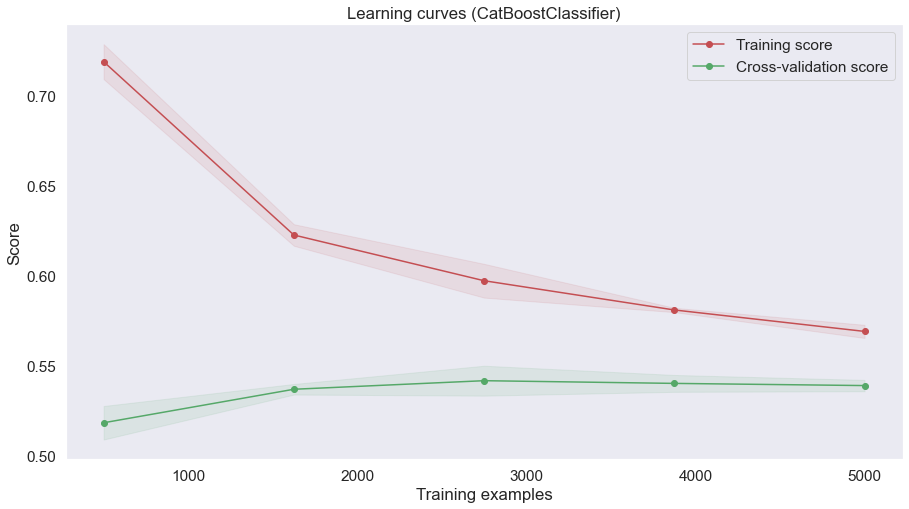

In [68]:
# Строю график зависимости целевой метрики от количества наблюдений для трейна и кросс-валидации

show_learning_curve_plot(final_model, X, y)

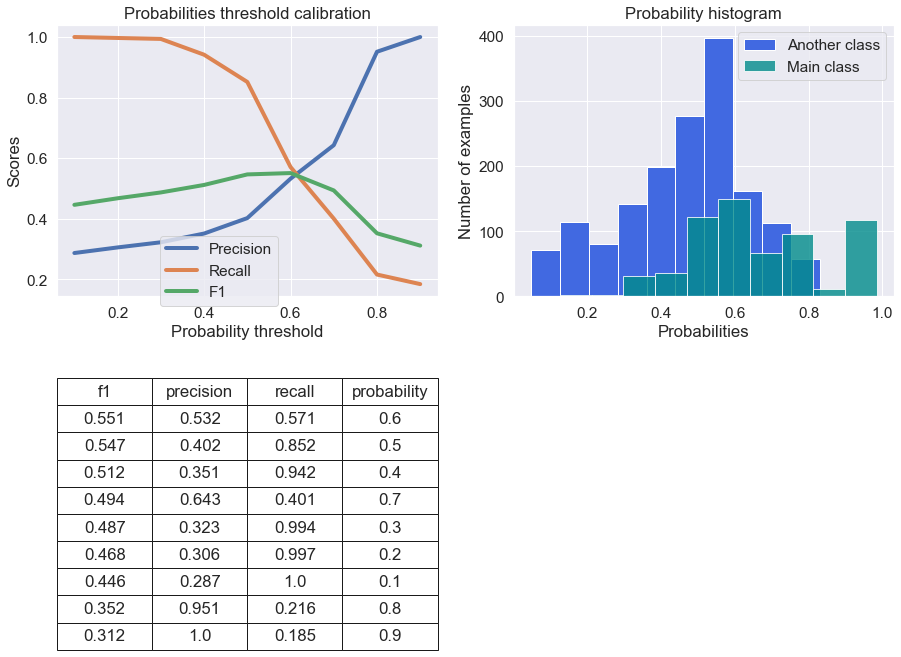

In [69]:
# Строю визуализацию с иллюстрацией оптимальной отсечки по тесту
# Зеленая линия (метрика f1) - гармоническое среднее между оранжевой (recall) и синей (precision)
# Судя по графику, лучшая отсечка для f1 около 0.6 - это подтверждает табличка с распределением вероятности по метрикам

show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

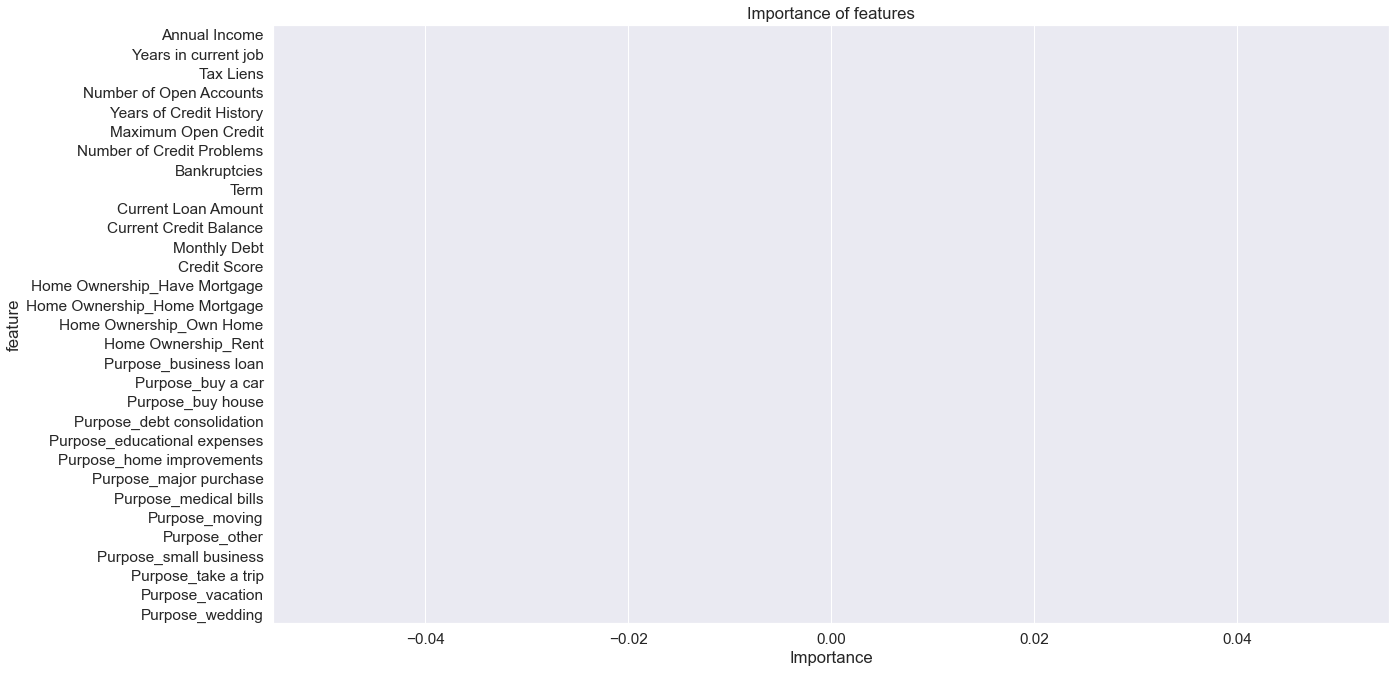

In [70]:
# Вывожу значимость признаков 

important_features_top = show_feature_importances(feature_names, final_model.feature_importances_, get_top=15)

In [71]:
# Смотрю самые влиятельные признаки

important_features_top

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage']

In [72]:
# Сохранение финальной модели

with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Интерпретация результатов

Разные модели за разное время посчитали метрики на трейне и на тесте: 

**LogisticRegression**: 0,35 секунды; 0.48 / 0.47 - неплохой результат, но целевая метрика < 0.5

**KNeighborsClassifier**: 4,5 секунды; 0.5 / 0.27 - немного возросло переобучение, целевая метрика очень мала

**xgb.XGBClassifier**: 3 секунды; 0.94 / 0.47 - резко возросло переобучение, целевая метрика < 0.5 

**lgbm.LGBMClassifier**: 1 секунда; 0.88 / 0.51 - переобучение, целевая метрика > 0.5 - хороший результат 

**catb.CatBoostClassifier**: 15,9 секунды; 0.77 / 0.54 - самое большое время, но небольшое переобучение, самое главное целевая метрика > 0.5

Был выбран CatBoost.

Настроены гиперпараметры; уменьшение переобучения при помощи L2-регуляризации увенчалось успехом. Кроме того - рост целевой метрики до 0.55. 

Зафиксирована финальная модель. 

По графикам зафиксировано значение целевой метрики от количества наблюдений для обучающей и кросс-валидационной выборок, проанализированы зависимость от Precision и Recall, гистограммы вероятностей классов целевой переменной. 

### Прогнозирование на тестовом датасете

In [73]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [74]:
df_test.shape

(2500, 16)

In [75]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [76]:
df_test.iloc[0]

Home Ownership                                Rent
Annual Income                                  NaN
Years in current job                       4 years
Tax Liens                                      0.0
Number of Open Accounts                        9.0
Years of Credit History                       12.5
Maximum Open Credit                       220968.0
Number of Credit Problems                      0.0
Months since last delinquent                  70.0
Bankruptcies                                   0.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                       162470.0
Current Credit Balance                    105906.0
Monthly Debt                                6813.0
Credit Score                                   NaN
Name: 0, dtype: object

In [77]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [78]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

In [79]:
# Обнаруживаю пропуски 

len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [80]:
# Заменяю пропуски в признаке Annual Income на медиану

df_test['Annual Income'].fillna(df_test['Annual Income'].median(), inplace=True)
df_test['Annual Income'].isna().sum()

0

In [81]:
# Заполняю пропуски в признаке Years in current job модой

df_test['Years in current job'].fillna(df_test['Years in current job'].mode()[0], inplace=True)
df_test['Years in current job'].isna().sum()

0

In [82]:
# Вижу в признаке Months since last delinquent пропуски, количество которых больше половины - убираю его

df_test = df_test.drop('Months since last delinquent', axis=1)

In [83]:
# Заполняю пропуски в признаке Bankruptcies модой

df_test['Bankruptcies'].fillna(df_test['Bankruptcies'].mode()[0], inplace=True)
df_test['Bankruptcies'].isna().sum()

0

In [84]:
# Заменяю пропуски в признаке Credit Score на медиану

df_test['Credit Score'].fillna(df_test['Credit Score'].median(), inplace=True)
df_test['Credit Score'].isna().sum()

0

In [85]:
# Проверяю на отсутствие пропусков

df_test.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
dtype: int64

In [86]:
# Поработаю с признаком Maximum Open Credit
# Это наибольший открытый кредит, поэтому предполагаю, что нулевых значений тут быть не может

df_test['Maximum Open Credit'].value_counts()

0.0          14
220968.0      2
674344.0      2
1138478.0     2
437228.0      2
             ..
181764.0      1
604406.0      1
248512.0      1
215666.0      1
1199748.0     1
Name: Maximum Open Credit, Length: 2435, dtype: int64

In [87]:
df_test['Maximum Open Credit'].describe()

count    2.500000e+03
mean     7.105704e+05
std      1.511983e+06
min      0.000000e+00
25%      2.785860e+05
50%      4.786760e+05
75%      8.025985e+05
max      5.448439e+07
Name: Maximum Open Credit, dtype: float64

In [88]:
# Вижу 14 отклонений

df_test[df_test['Maximum Open Credit'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
311,Home Mortgage,1230440.0,1 year,0.0,10.0,16.2,0.0,0.0,0.0,other,Long Term,547976.0,0.0,308.0,701.0
426,Rent,361760.0,< 1 year,0.0,4.0,11.6,0.0,0.0,0.0,debt consolidation,Short Term,15422.0,0.0,3738.0,718.0
1036,Home Mortgage,2328906.0,5 years,0.0,4.0,16.4,0.0,0.0,0.0,other,Short Term,434940.0,51775.0,3125.0,735.0
1343,Home Mortgage,2400061.0,10+ years,0.0,1.0,17.0,0.0,0.0,0.0,debt consolidation,Short Term,494648.0,0.0,1500.0,709.0
1373,Rent,1178475.0,< 1 year,0.0,5.0,10.7,0.0,0.0,0.0,other,Short Term,276452.0,11533.0,283.0,731.0
1710,Rent,2154638.0,1 year,0.0,4.0,16.4,0.0,0.0,0.0,debt consolidation,Short Term,227788.0,0.0,25856.0,709.0
1738,Rent,1383732.0,10+ years,0.0,5.0,20.5,0.0,0.0,0.0,debt consolidation,Short Term,89012.0,0.0,6711.0,731.0
1751,Rent,1135098.0,4 years,0.0,6.0,18.0,0.0,0.0,0.0,other,Short Term,214676.0,114.0,13716.0,748.0
1810,Home Mortgage,456646.0,10+ years,0.0,5.0,18.8,0.0,0.0,0.0,wedding,Short Term,99999999.0,0.0,2481.0,746.0
1837,Rent,394725.0,3 years,0.0,3.0,10.0,0.0,0.0,0.0,other,Long Term,52734.0,0.0,3434.0,692.0


In [89]:
# Заменяю нулевые значения в Maximum Open Credit на моду
# Вижу, что теперь значения признака Maximum Open Credit вписываются в объективные

df_test.loc[df_test['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = df_test['Maximum Open Credit'].mode()[0]
df_test['Maximum Open Credit'].describe()

count    2.500000e+03
mean     7.105704e+05
std      1.511983e+06
min      0.000000e+00
25%      2.785860e+05
50%      4.786760e+05
75%      8.025985e+05
max      5.448439e+07
Name: Maximum Open Credit, dtype: float64

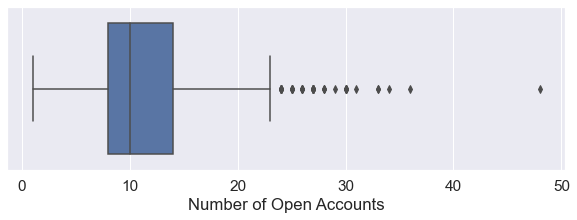

In [90]:
# Ищу выбросы в Number of Open Accounts с помощью box plot

plt.figure(figsize=(10, 3))

sns.boxplot(df_test['Number of Open Accounts'], whis=1.5)

plt.xlabel('Number of Open Accounts')
plt.show()

In [91]:
# Заменяю выбросы в Number of Open Accounts на медиану

df_test.loc[df_test['Number of Open Accounts'] > 23, 'Number of Open Accounts'] = df_test['Number of Open Accounts'].median()

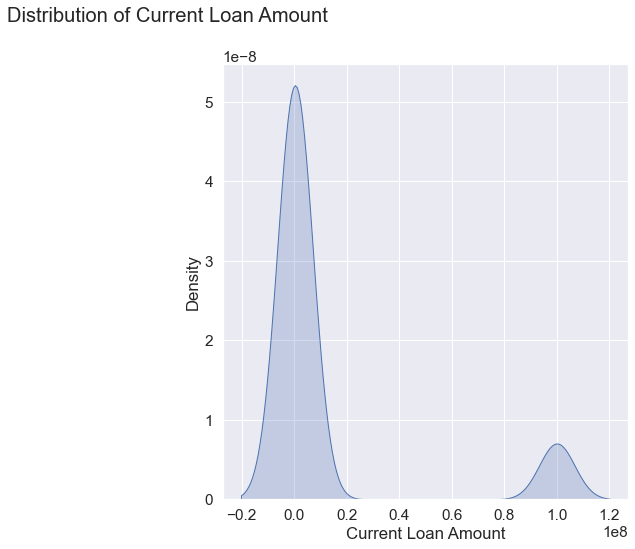

In [92]:
# Поработаю с признаком Current Loan Amount

plt.figure(figsize = (16, 8))

plt.subplot(122)
sns.kdeplot(df_test['Current Loan Amount'], shade=True, legend=False)
plt.xlabel('Current Loan Amount')

plt.suptitle('Distribution of Current Loan Amount')
plt.show()

In [93]:
# Скачок в районе 100 млн выглядит странно

df_test['Current Loan Amount'].max()

99999999.0

In [94]:
# Более того - это еще и самое часто встречающеея значение

df_test['Current Loan Amount'].mode()

0    99999999.0
Name: Current Loan Amount, dtype: float64

In [95]:
# Предполагаю, что это какое-то стандартное заведомо большое значение размера кредита для заполнения случаев, 
# когда истинная сумма неизвестна

df_test['Current Loan Amount'].loc[df_test['Current Loan Amount'] == 99999999.0].count()

297

In [96]:
# Расцениваю это как выбросы и с учетом количества таких примеров, считаю что они могут повлиять на итоговые предсказания -
# поэтому заменяю их на медиану

df_test['Current Loan Amount'].loc[df_test['Current Loan Amount'] == 99999999.0] = df_test['Current Loan Amount'].median() 

In [97]:
# Обрабатываю категориальные признаки: 
# бинарный перевод для признака Term 
# порядковые числа для признака Years in current job
# бинарное кодирование через dummy-переменные

df_test['Term'] = df_test['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)

In [98]:
df_test['Years in current job'] = df_test['Years in current job'].map({
                                                                        '10+ years':'10', 
                                                                        '< 1 year':'0',
                                                                        '1 year':'1',    
                                                                        '2 years':'2',
                                                                        '3 years':'3',
                                                                        '4 years':'4',
                                                                        '5 years':'5',
                                                                        '6 years':'6',
                                                                        '7 years':'7',
                                                                        '8 years':'8',
                                                                        '9 years':'9'}).astype(int)

In [99]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [100]:
df_test = df_test.drop(df_test.select_dtypes(include='object').columns, axis=1)

In [101]:
# Сохранение предобработанного (подготовленного) тестового датасета

PREP_TEST_DATASET_PATH  = '../course_project_test_prep.csv'

df_test.to_csv(PREP_TEST_DATASET_PATH, index=False, encoding='utf-8')

In [102]:
# Подгрузка сабмишена с kaggle 

submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [103]:
final_model.fit(X, y)

In [104]:
# Предсказание классов целевой переменной в тесте 

predictions = final_model.predict(df_test)
predictions

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [105]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


In [106]:
# Выгрузка в файл CSV с прогнозами целевой переменной для тестового датасета  

submit.to_csv('NVKrivonogov_predictions.csv', index=False)